In [219]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

import pymannkendall as mk
from functions import autocorrelation_criterion

PATH_TO_DATA = "data/data_with_return.csv"
SEED = 404

In [59]:
df = pd.read_csv(PATH_TO_DATA, encoding='UTF-16', parse_dates=["TRADEDATE"])
df.sample(5, random_state=SEED)

,TRADEDATE,SECID,NUMTRADES,LEGALCLOSEPRICE,CLOSE,VOLUME,TRENDCLSPR,RETURN
30125,2018-09-17,VZRZ,37,431.0000,431.00000,534,-1.15,-0.011534
10497,2018-04-04,TGKN,34,0.0053,0.00536,98000000,2.88,0.017127
8842,2018-03-21,MSST,50,1.1200,1.12000,24400,0.00,0.004474
24844,2018-08-02,MSRS,113,0.7260,0.72800,4320000,0.28,0.000000
38823,2018-11-29,RUGR,1754,6.2800,6.28000,590660,0.88,0.008797


In [212]:
significant_stocks = df.groupby(by="SECID", as_index=False).agg({"VOLUME": "median"}).sort_values(by="VOLUME", ascending=False).head(5).SECID
significant_stocks

160    VTBR
141    TGKA
30     FEES
40     HYDR
142    TGKB
Name: SECID, dtype: object

In [208]:
df_with_month = df.assign(MONTH=df.TRADEDATE.dt.month_name())
df_with_month.head()

,TRADEDATE,SECID,NUMTRADES,LEGALCLOSEPRICE,CLOSE,VOLUME,TRENDCLSPR,RETURN,MONTH
0,2018-01-03,AFKS,5071,12.350,12.350,20687500,2.15,0.0,January
1,2018-01-03,QIWI,687,980.000,980.000,24387,7.69,0.0,January
2,2018-01-03,RASP,4154,91.410,91.410,1389510,2.70,0.0,January
3,2018-01-03,RBCM,124,5.805,5.805,104100,0.61,0.0,January
4,2018-01-03,RGSS,13,0.424,0.424,396000,-0.47,0.0,January


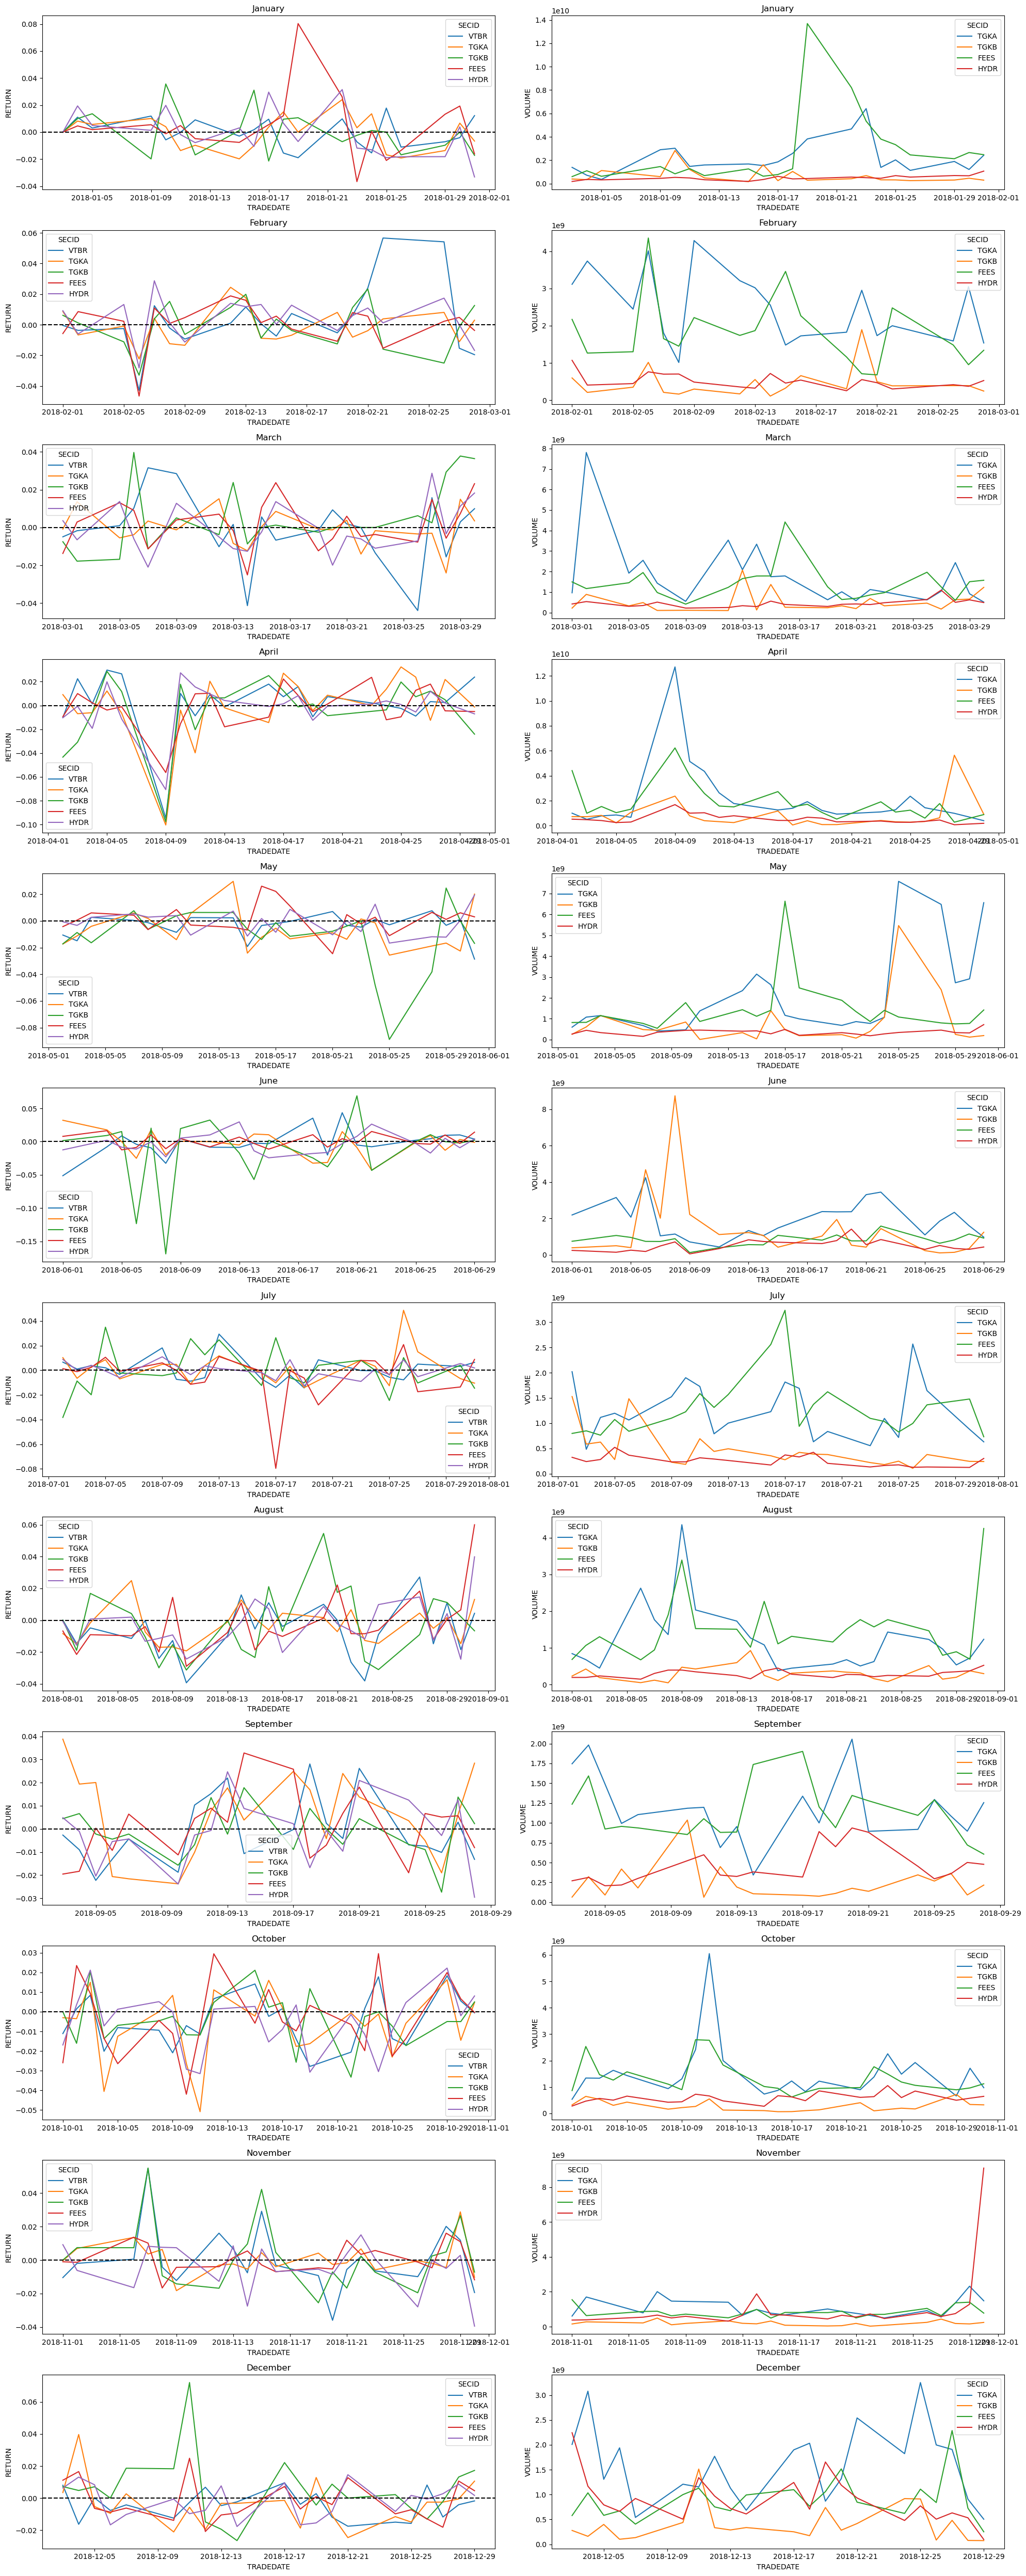

In [213]:
fig, ax = plt.subplots(12, 2, figsize=(20, 50))

for i, month in enumerate(df_with_month.MONTH.unique()):
    df_month_window = df_with_month[df_with_month.MONTH == month]
    sns.lineplot(data=df_month_window[df_month_window.SECID.isin(significant_stocks)], x="TRADEDATE", y="RETURN", hue="SECID", ax=ax[i][0]);
    sns.lineplot(data=df_month_window[df_month_window.SECID.isin(significant_stocks.tail(4))], x="TRADEDATE", y="VOLUME", hue="SECID", ax=ax[i][1]);
    # sns.histplot(data=df_month_window[df_month_window.SECID.isin(significant_stocks)], x="RETURN", hue="SECID", ax=ax[i][1], alpha=0.6, bins=30);
    ax[i][0].set_title(month)
    ax[i][1].set_title(month)
    ax[i][0].axhline(0, ls='--', color='black')
fig.tight_layout()

Автокорреляция

In [237]:
ALPHA = 0.05
SHIFT = 1

In [238]:
isTrend = False
print(f"Проверка тренда (диапозон 1 год == {df.TRADEDATE.nunique()} наблюдений) критерием автокорреляции на доходностях.")
for stock in significant_stocks:
    criterion_dict = autocorrelation_criterion(df[df.SECID == stock].RETURN, ALPHA, SHIFT)
    if criterion_dict['trend']:
        print("Есть тренд у актива:", stock)
        isTrend = True
        
if not isTrend:
    print("Тренда нет")

isTrend = False
print(f"Проверка тренда (диапозон 1 год == {df.TRADEDATE.nunique()} наблюдений) критерием автокорреляции на объеме.") 
for stock in significant_stocks:
    criterion_dict = autocorrelation_criterion(df[df.SECID == stock].VOLUME, ALPHA, SHIFT)
    if criterion_dict['trend']:
        print("Есть тренд у актива:", stock)
        isTrend = True
        
if not isTrend:
    print("Тренда нет")

Проверка тренда (диапозон 1 год == 254 наблюдений) критерием автокорреляции на доходностях.
Тренда нет
Проверка тренда (диапозон 1 год == 254 наблюдений) критерием автокорреляции на объеме.
Тренда нет


In [239]:
# Проверим каждый месяц

trend_dict = {"month": [], "stock": [], "isTrend": [], "observations": []}
for month in df_with_month.MONTH.unique():
    for stock in significant_stocks:
        temp_df = df_with_month[(df_with_month.SECID == stock) & (df_with_month.MONTH == month)]
        cr = autocorrelation_criterion(temp_df.RETURN, ALPHA, SHIFT)
        trend_dict["month"].append(month)
        trend_dict["stock"].append(stock)
        trend_dict["isTrend"].append(cr["trend"])
        trend_dict["observations"].append(temp_df.TRADEDATE.nunique())
        
trend_df = pd.DataFrame(trend_dict)
print("RETURNS")
trend_df[(trend_df.isTrend == True) & (trend_df.observations > 10)]

RETURNS


,month,stock,isTrend,observations
8,February,HYDR,True,19
24,May,TGKB,True,21
41,September,TGKA,True,20


In [240]:
# Проверим каждый месяц

trend_dict = {"month": [], "stock": [], "isTrend": [], "observations": []}
for month in df_with_month.MONTH.unique():
    for stock in significant_stocks:
        temp_df = df_with_month[(df_with_month.SECID == stock) & (df_with_month.MONTH == month)]
        cr = autocorrelation_criterion(temp_df.VOLUME, ALPHA, SHIFT)
        trend_dict["month"].append(month)
        trend_dict["stock"].append(stock)
        trend_dict["isTrend"].append(cr["trend"])
        trend_dict["observations"].append(temp_df.TRADEDATE.nunique())
        
trend_df = pd.DataFrame(trend_dict)
print("VOLUME")
trend_df[(trend_df.isTrend == True) & (trend_df.observations > 10)]

VOLUME


,month,stock,isTrend,observations
3,January,HYDR,True,20
4,January,TGKB,True,20
9,February,TGKB,True,19
13,March,HYDR,True,21
14,March,TGKB,True,21
18,April,HYDR,True,22
27,June,FEES,True,21
28,June,HYDR,True,21
33,July,HYDR,True,22
34,July,TGKB,True,22


In [245]:
print('RETURNS\n')
trend_dict = {"stock": [], "trend": []}
for stock in significant_stocks:
    result = mk.original_test(df[df.SECID == stock].RETURN, alpha=ALPHA)
    trend_dict["stock"].append(stock)
    trend_dict["trend"].append(getattr(result, "trend"))

pd.DataFrame(trend_dict)

RETURNS



,stock,trend
0,VTBR,decreasing
1,TGKA,no trend
2,FEES,no trend
3,HYDR,no trend
4,TGKB,no trend


In [247]:
print('VOLUME\n')
trend_dict = {"stock": [], "trend": []}
for stock in significant_stocks:
    result = mk.original_test(df[df.SECID == stock].VOLUME, alpha=ALPHA)
    trend_dict["stock"].append(stock)
    trend_dict["trend"].append(getattr(result, "trend"))

pd.DataFrame(trend_dict)

VOLUME



,stock,trend
0,VTBR,decreasing
1,TGKA,decreasing
2,FEES,decreasing
3,HYDR,increasing
4,TGKB,decreasing


In [251]:
# Проверим каждый месяц

trend_dict = {"month": [], "stock": [], "isTrend": [], "observations": []}
for month in df_with_month.MONTH.unique():
    for stock in significant_stocks:
        temp_df = df_with_month[(df_with_month.SECID == stock) & (df_with_month.MONTH == month)]
        cr = mk.original_test(temp_df.VOLUME, alpha=ALPHA)
        trend_dict["month"].append(month)
        trend_dict["stock"].append(stock)
        trend_dict["isTrend"].append(getattr(cr, "trend"))
        trend_dict["observations"].append(temp_df.TRADEDATE.nunique())
        
trend_df = pd.DataFrame(trend_dict)
print("VOLUME")
trend_df[(trend_df.isTrend != "no trend")]

VOLUME


,month,stock,isTrend,observations
2,January,FEES,increasing,20
3,January,HYDR,increasing,20
11,March,TGKA,decreasing,21
13,March,HYDR,increasing,21
15,April,VTBR,decreasing,22
17,April,FEES,decreasing,22
18,April,HYDR,decreasing,22
21,May,TGKA,increasing,21
30,July,VTBR,decreasing,22
33,July,HYDR,decreasing,22
